# Visualize Learning Curves

In [9]:
# 必要なライブラリのインポート
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math

In [10]:
LINE_WIDTH = 2.5
FONT_SIZE = 20
FIG_SIZE = (10, 6)
SOLID_ALPHA = 0.9
SHADED_ALPHA = 0.2
COLOR = plt.get_cmap('Dark2')  # カラーマップ 　tab10 や Dark2 など

plt.rcParams.update(
    {
        'font.size': FONT_SIZE,
        'legend.fontsize': FONT_SIZE * 1.05,
        'text.usetex': True,
        'axes.linewidth': LINE_WIDTH,
        'xtick.major.width': LINE_WIDTH,
        'ytick.major.width': LINE_WIDTH,
        'xtick.major.size': 2*LINE_WIDTH,
        'ytick.major.size': 2*LINE_WIDTH,
        "lines.linewidth": LINE_WIDTH,
    }
)

In [11]:
DATA_DIRS = [
    'data/deep4/experiment/20250915_131732_MG_GCP_GuidedCartPole-v1/20250928_081108_MG_GCP_GuidedCartPole-v1_STDDPG_ui_1_aui_10/eval/aggregated_itr_200',
    'data/deep4/experiment/20250915_131732_MG_GCP_GuidedCartPole-v1/20250928_075244_MG_GCP_GuidedCartPole-v1_STDDPG_ui_10_aui_1/eval/aggregated_itr_200',
    'data/deep4/experiment/20250915_131732_MG_GCP_GuidedCartPole-v1/20250928_080949_MG_GCP_GuidedCartPole-v1_STDDPG_ui_10_aui_10/eval/aggregated_itr_200',
    ]
# Note: the order in the legend follows the order in list DATA_DIRS
INCLUDE = [
    'MG_GCP_GuidedCartPole-v1_L_algo_STDDPG_update_interval_1_actor_update_interval_10_policy_lr_1e-05_qf_lr_1e-04_replay_buffer_size_500_',
    'MG_GCP_GuidedCartPole-v1_L_algo_STDDPG_update_interval_10_actor_update_interval_1_policy_lr_1e-05_qf_lr_1e-04_replay_buffer_size_500_',
    'MG_GCP_GuidedCartPole-v1_L_algo_STDDPG_update_interval_10_actor_update_interval_10_policy_lr_1e-04_qf_lr_1e-03_replay_buffer_size_500_'
    ]  # この文字列を名前に含むデータのみプロット
EXCLUDE = [
    ]  # この文字列を名前に含むデータはプロットしない
# 凡例のラベル、線種、色の指定
LABELS = {
    (INCLUDE[0],): 'MG_GCP_GuidedCartPole-v1_L_algo_STDDPG_update_interval_1_actor_update_interval_10_policy_lr_1e-05_qf_lr_1e-04_replay_buffer_size_500_'.replace('_', '-'),
    (INCLUDE[1],): 'MG_GCP_GuidedCartPole-v1_L_algo_STDDPG_update_interval_10_actor_update_interval_1_policy_lr_1e-05_qf_lr_1e-04_replay_buffer_size_500_'.replace('_', '-'),
    (INCLUDE[2],): 'MG_GCP_GuidedCartPole-v1_L_algo_STDDPG_update_interval_10_actor_update_interval_10_policy_lr_1e-04_qf_lr_1e-03_replay_buffer_size_500_'.replace('_', '-')
}
LINESTYLES = {
    ('update_interval_1_actor_update_interval_10_',): '-',
    ('update_interval_10_actor_update_interval_1_',): '--',
    ('update_interval_10_actor_update_interval_10_',): ':'
}
COLORS = {
    ('update_interval_1_actor_update_interval_10_',): COLOR(0),
    ('update_interval_10_actor_update_interval_1_',): COLOR(1),
    ('update_interval_10_actor_update_interval_10_',): COLOR(2)   
}

# Save options
SAVE_FIGURE = False  # 図を保存するか
SAVE_DIR = os.getcwd()  # 保存先ディレクトリ（Noneなら 各データディレクトリ内のfiguresに保存）

# Plot options
METRICS = ['Evaluation/AverageTargetReturn']  # 可視化したいメトリクス
X_AXIS = 'TotalEnvSteps'  # x軸に使う量
MAX_X_VALUE = 50000

Y_LABEL = 'Upper-level return'  # y軸のラベル（Noneなら自動生成）
X_LABEL = 'Steps'  # x軸のラベル（Noneなら自動生成）
TITLE = None

LEGEND_POSITION = {
    'loc': 'outer',  # outer: ledendを図の外側固定位置に配置, upper right: 右上に配置, upper left: 左上に配置, lower right: 右下に配置, lower left: 左下に配置
    'bbox_to_anchor': (1.0, 0.55),
    'ncol': 1
}

In [12]:
# plot.pyの関数をノートブック用に再定義
def find_dirs_end_with(dir, keyword):
    found_dirs = []
    for root, dirs, files in os.walk(dir):
        for d in dirs:
            if d.endswith(keyword):
                found_dirs.append(os.path.join(root, d))
    found_dirs.sort()
    return found_dirs

def find_files_end_with(dir, keyword):
    found_files = []
    for root, dirs, files in os.walk(dir):
        for f in files:
            if f.endswith(keyword):
                found_files.append(os.path.join(root, f))
    found_files.sort()
    return found_files

## Load Data

In [13]:
# --- データの読み込み --- #
current_dir = os.getcwd()
DATA_DIRS = [os.path.join(current_dir, d) if not os.path.isabs(d) else d for d in DATA_DIRS]

ave_data_for_plot = {DATA_DIR: [] for DATA_DIR in DATA_DIRS}
std_data_for_plot = {DATA_DIR: [] for DATA_DIR in DATA_DIRS}
x_data_for_plot = {DATA_DIR: [] for DATA_DIR in DATA_DIRS}
label_list = {DATA_DIR: [] for DATA_DIR in DATA_DIRS}
color_id_list = {DATA_DIR: [] for DATA_DIR in DATA_DIRS}
i = 0
for DATA_DIR in DATA_DIRS:
    
    ave_sep_data_list = []
    std_sep_data_list = []

    # 'average' ディレクトリを探索
    print('Source log directory:', DATA_DIR)

    ave_dirs = find_dirs_end_with(DATA_DIR, 'average')

    if not len(ave_dirs) > 0:
        raise FileNotFoundError(f"No directory with 'average' found in {DATA_DIR}")

    for ave_dir in ave_dirs:
        ave_paths = find_files_end_with(ave_dir, 'progress_average.csv')
        # 'std' ディレクトリを探索
        std_paths = find_files_end_with(ave_dir.replace('average', 'std'), 'progress_std.csv')

        if not (len(ave_paths) > 0 and len(std_paths) > 0):
            raise FileNotFoundError(f"No progress_average.csv or progress_std.csv found in {ave_dir}")
        
        # print('Data found in:', ave_dir)

        # Load
        ave_data = [pd.read_csv(p) for p in ave_paths]  # [eval, follower, leader]
        std_data = [pd.read_csv(p) for p in std_paths]  # [eval, follower, leader]
        ave_sep_data_list.append(ave_data)
        std_sep_data_list.append(std_data)

    # --- Plot するデータの抽出 --- #

    for ave_data, std_data, ave_dir in zip(ave_sep_data_list, std_sep_data_list, ave_dirs):

        label = ave_dir.rstrip('/').split('/')[-1]  # ディレクトリ名を抽出

        ave_for_metrics = {}
        std_for_metrics = {}
        x_for_metrics = {}
        extracted = []
        for metric in METRICS:
            for ave, std in zip(ave_data, std_data):
                if metric in ave.columns:
                    if metric in extracted:
                        raise ValueError(f"Multiple data found for {metric} in {ave_dir}")
                    ave_for_metrics[metric] = ave[metric]
                    std_for_metrics[metric] = std[metric]
                    x_for_metrics[metric] = ave[X_AXIS]
                    extracted.append(metric)

        ave_data_for_plot[DATA_DIR].append(ave_for_metrics)
        std_data_for_plot[DATA_DIR].append(std_for_metrics)
        x_data_for_plot[DATA_DIR].append(x_for_metrics)
        label_list[DATA_DIR].append(label)
        color_id_list[DATA_DIR].append(i % COLOR.N)
        i += 1

Source log directory: /home/mikoto/workspace/ptia/data/deep4/experiment/20250915_131732_MG_GCP_GuidedCartPole-v1/20250928_081108_MG_GCP_GuidedCartPole-v1_STDDPG_ui_1_aui_10/eval/aggregated_itr_200
Source log directory: /home/mikoto/workspace/ptia/data/deep4/experiment/20250915_131732_MG_GCP_GuidedCartPole-v1/20250928_075244_MG_GCP_GuidedCartPole-v1_STDDPG_ui_10_aui_1/eval/aggregated_itr_200
Source log directory: /home/mikoto/workspace/ptia/data/deep4/experiment/20250915_131732_MG_GCP_GuidedCartPole-v1/20250928_080949_MG_GCP_GuidedCartPole-v1_STDDPG_ui_10_aui_10/eval/aggregated_itr_200


In [14]:
def plot_average_with_std(
        ave_data: list, std_data: list, x_data: list, metric: str,
        labels: list = None, colors: list = None, linestyles: list = None,
        solid_alpha: float = SOLID_ALPHA, shaded_alpha: float = SHADED_ALPHA,
        xlim: tuple = (0, MAX_X_VALUE), ylim: tuple = None,
        x_label: str = 'Steps', y_label: str = None,
        title: str = None, show_legend: bool = True, save_figure: bool = False, tag: str = ''
    ):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    labels = [i for i in range(len(ave_data))] if labels is None else labels
    colors = [COLOR(i % COLOR.N) for i in range(len(ave_data))] if colors is None else colors
    linestyles = ['-'] * len(ave_data) if linestyles is None else linestyles
    zipped = zip(ave_data, std_data, x_data, labels, colors, linestyles)
    for ave, std, x, label, color, linestyle in zipped:
        ax.plot(x[metric], ave[metric], label=label, color=color, alpha=solid_alpha, linestyle=linestyle)
        ax.fill_between(x[metric], 
                        ave[metric] - std[metric], 
                        ave[metric] + std[metric], 
                        color=color, alpha=shaded_alpha)
    ax.set_xlabel(x_label)
    y_label = metric if y_label is None else y_label
    ax.set_ylabel(y_label)
    if title is not None:
        ax.set_title(title)
    if show_legend:
        if LEGEND_POSITION['loc'] == 'outer':
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend(**LEGEND_POSITION)
    ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
    plt.show()

    # 保存
    if save_figure:
        _log_dir = os.getcwd()  # current directory
        _save_dir = SAVE_DIR if SAVE_DIR is not None else os.path.join(_log_dir, 'figures')
        os.makedirs(_save_dir, exist_ok=True)
        metric_label = metric.replace('/', '_')
        suffix = f'_{tag}' if tag != '' else ''
        file_name = f'{metric_label}_AveStd{suffix}.png'
        fig.savefig(os.path.join(_save_dir, file_name), bbox_inches='tight')
        print('Saved at', os.path.join(_save_dir, file_name))

    info = {'xlim': ax.get_xlim(), 'ylim': ax.get_ylim()}
    plt.close(fig)
    return info

def color_linestyle_label_matching(label_all, color_id_all):
    # color and linestyle matching
    colors = []
    linestyles = []
    labels = []
    for label, ci in zip(label_all, color_id_all):
        color = COLOR(ci)
        if COLORS is not None:
            for ks, c in COLORS.items():
                if all([k in label for k in ks]):
                    color = c
                    break
        colors.append(color)

        linestyle = '-'
        if LINESTYLES is not None:
            for ks, s in LINESTYLES.items():
                if all([k in label for k in ks]):
                    linestyle = s
                    break
        linestyles.append(linestyle)

        if LABELS is not None:
            for ks, l in LABELS.items():
                if all([k in label for k in ks]):
                    label = l
                    break
        elif label.endswith('_average'):
            label = label[:-len('_average')]
        labels.append(label)
    return colors, linestyles, labels

## Plot data included in INCLUDE within a single figure


* --- Mertric: Evaluation/AverageTargetReturn --- *


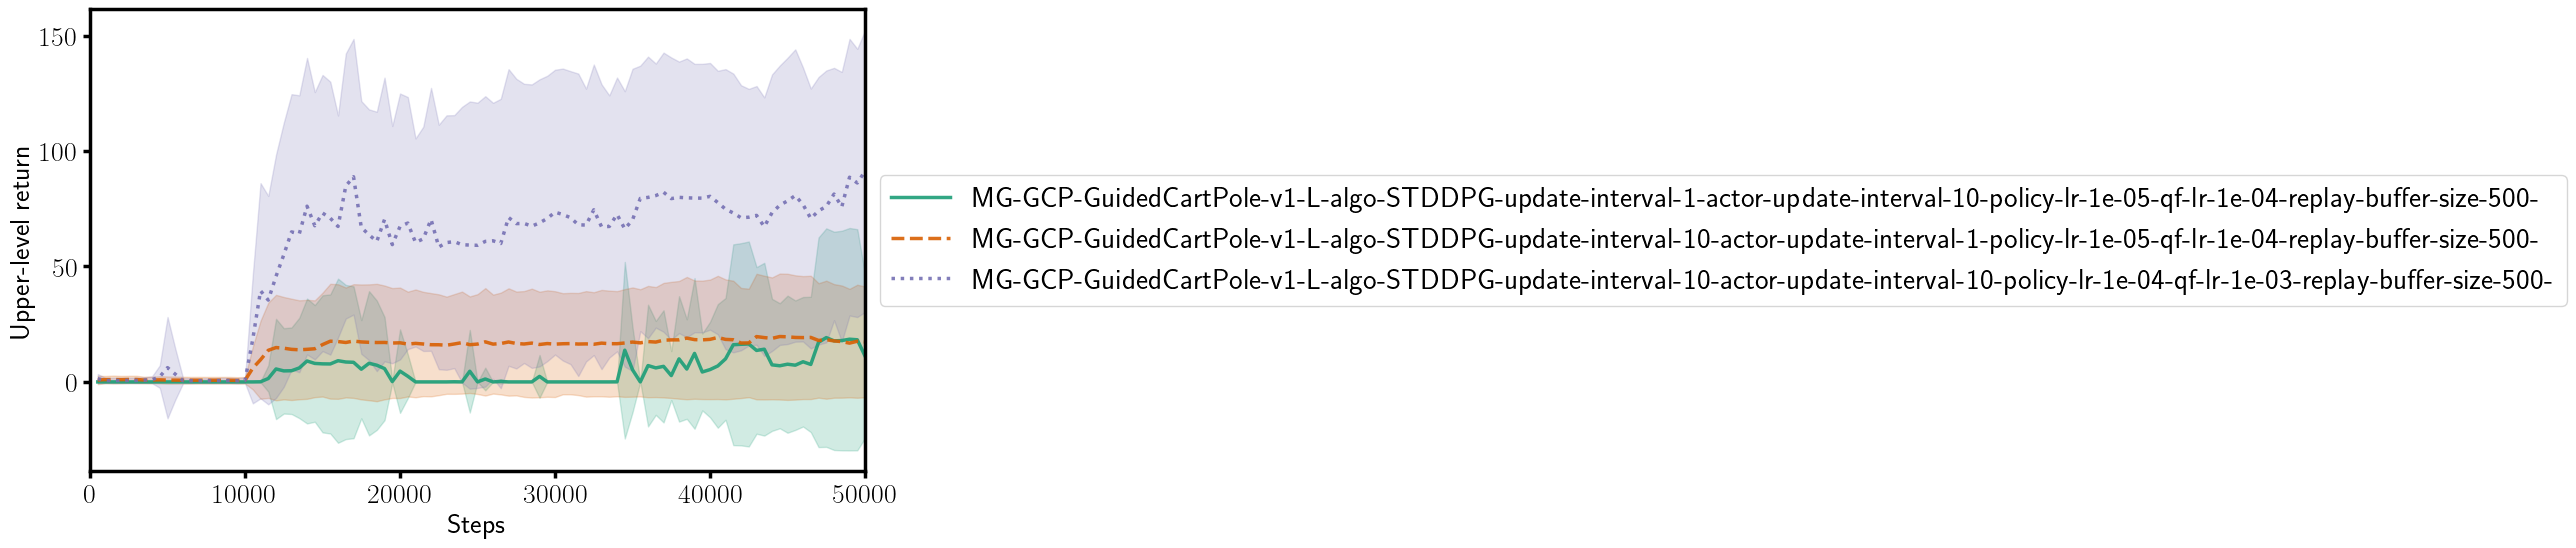

average ± std (over last 10 epochs):
MG-GCP-GuidedCartPole-v1-L-algo-STDDPG-update-interval-1-actor-update-interval-10-policy-lr-1e-05-qf-lr-1e-04-replay-buffer-size-500-:
14.35 ± 41.36
MG-GCP-GuidedCartPole-v1-L-algo-STDDPG-update-interval-10-actor-update-interval-1-policy-lr-1e-05-qf-lr-1e-04-replay-buffer-size-500-:
18.09 ± 25.18
MG-GCP-GuidedCartPole-v1-L-algo-STDDPG-update-interval-10-actor-update-interval-10-policy-lr-1e-04-qf-lr-1e-03-replay-buffer-size-500-:
80.17 ± 58.81


In [15]:
# --- plot & notebook表示 --- #
ave_data_all = []
std_data_all = []
x_data_all = []
label_all = []
color_id_all = []

for DATA_DIR in DATA_DIRS:
    for ave, std, x, label, ci in zip(ave_data_for_plot[DATA_DIR], 
                                      std_data_for_plot[DATA_DIR], 
                                      x_data_for_plot[DATA_DIR], 
                                      label_list[DATA_DIR],
                                      color_id_list[DATA_DIR]):
        if any(inc in label for inc in INCLUDE) is False:
            continue
        if any(exc in label for exc in EXCLUDE) is True:
            continue
        ave_data_all.append(ave)
        std_data_all.append(std)
        x_data_all.append(x)
        label_all.append(label)
        color_id_all.append(ci)

if not len(label_all) > 0:
    raise ValueError("No data to plot. Please check INCLUDE and EXCLUDE filters.")

# color and linestyle matching
colors, linestyles, labels = color_linestyle_label_matching(label_all, color_id_all) 

for metric in METRICS:
    # plot
    print(f'\n* --- Mertric: {metric} --- *')
    info = plot_average_with_std(
        ave_data=ave_data_all, 
        std_data=std_data_all,
        x_data=x_data_all,
        labels=labels,
        metric=metric,
        colors=colors,
        linestyles=linestyles,
        x_label=X_LABEL,
        y_label=Y_LABEL,
        title=TITLE,
        show_legend=True,
        save_figure=SAVE_FIGURE
        )
    
    # 収束値の平均と標準偏差
    n = 10
    print(f'average ± std (over last {n} epochs):')
    for ave, std, label in zip(ave_data_all, std_data_all, labels):
        print(f'{label}:')
        print(f"{np.mean(ave[metric][-n:]):.2f} ± {np.sqrt(np.mean(std[metric][-n:]**2)):.2f}")

## Plot data of each DATA_DIR


* --- Mertric: Evaluation/AverageTargetReturn --- *


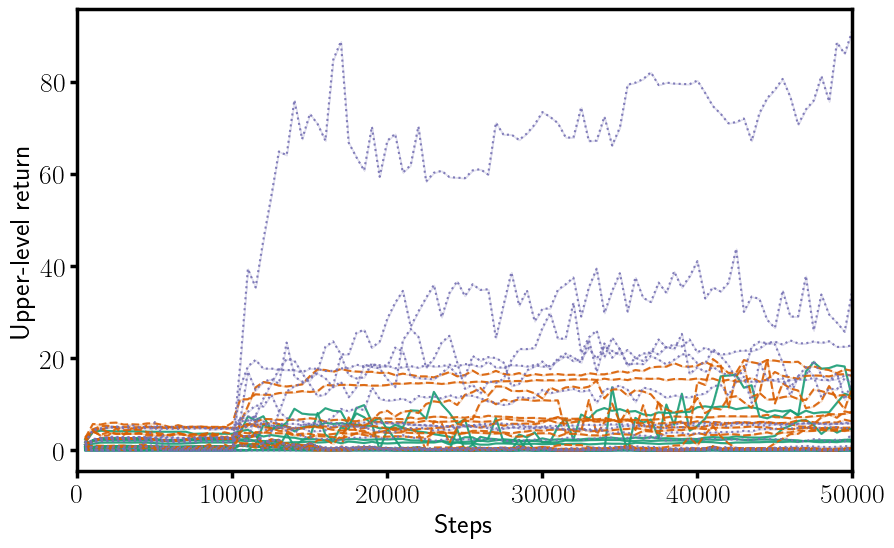


DATA_DIR: /home/mikoto/workspace/ptia/data/deep4/experiment/20250915_131732_MG_GCP_GuidedCartPole-v1/20250928_081108_MG_GCP_GuidedCartPole-v1_STDDPG_ui_1_aui_10/eval/aggregated_itr_200


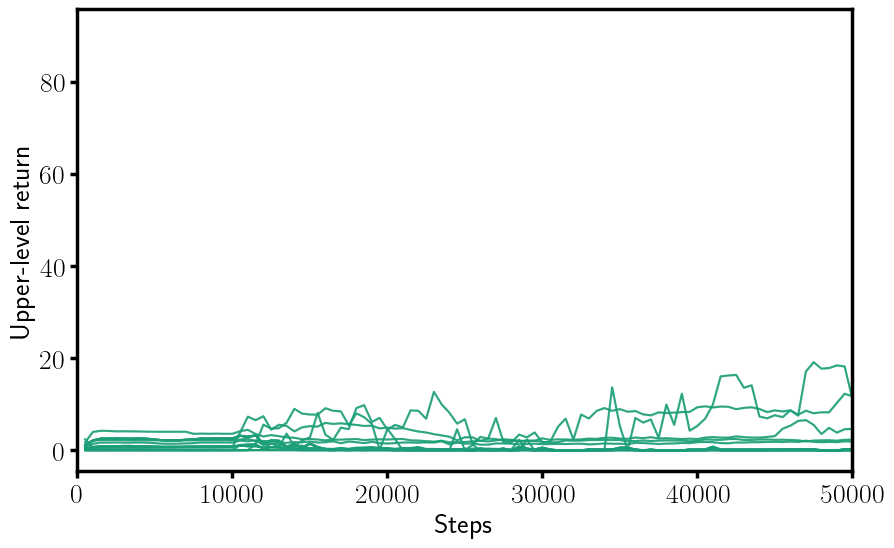


DATA_DIR: /home/mikoto/workspace/ptia/data/deep4/experiment/20250915_131732_MG_GCP_GuidedCartPole-v1/20250928_075244_MG_GCP_GuidedCartPole-v1_STDDPG_ui_10_aui_1/eval/aggregated_itr_200


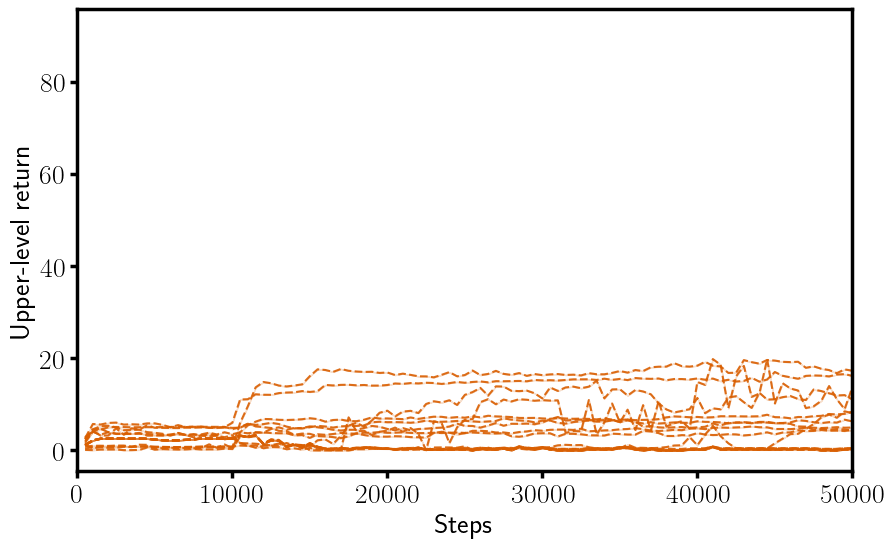


DATA_DIR: /home/mikoto/workspace/ptia/data/deep4/experiment/20250915_131732_MG_GCP_GuidedCartPole-v1/20250928_080949_MG_GCP_GuidedCartPole-v1_STDDPG_ui_10_aui_10/eval/aggregated_itr_200


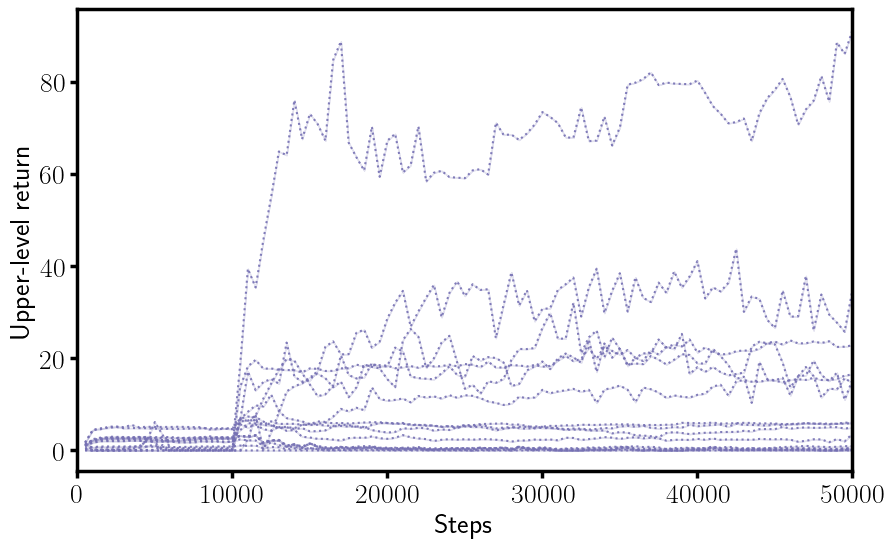

In [16]:
plt.rcParams.update(
    {
        "lines.linewidth": 1.5,
    }
)

ave_data_all = []
x_data_all = []
label_all = []
color_id_all = []

for DATA_DIR in DATA_DIRS:
    for ave, x, label, ci in zip(ave_data_for_plot[DATA_DIR], 
                                x_data_for_plot[DATA_DIR], 
                                label_list[DATA_DIR],
                                color_id_list[DATA_DIR]):
        ave_data_all.append(ave)
        x_data_all.append(x)
        label_all.append(label)
        color_id_all.append(ci)
colors_all, linestyles_all, _ = color_linestyle_label_matching(label_all, color_id_all)
zero_std_data_all = [{metric: [0.0] * len(d[metric])} for d in ave_data_all]

for metric in METRICS:
    print(f'\n* --- Mertric: {metric} --- *')
    # Plot all data
    info = plot_average_with_std(
        ave_data=ave_data_all, 
        std_data=zero_std_data_all,
        x_data=x_data_all,
        labels=None,
        metric=metric,
        colors=colors_all,
        linestyles=linestyles_all,
        x_label=X_LABEL,
        y_label=Y_LABEL,
        title=TITLE,
        show_legend=False,
        save_figure=SAVE_FIGURE,
        tag='all'
        )

    # Plot each DATA_DIR separately
    for i, DATA_DIR in enumerate(DATA_DIRS):
        # color and linestyle matching
        colors, linestyles, labels = color_linestyle_label_matching(label_list[DATA_DIR], 
                                                                    color_id_list[DATA_DIR]) 
        zero_std_data_for_plot = [{metric: [0.0] * len(d[metric])} for d in ave_data_for_plot[DATA_DIR]]
        # plot
        print(f'\nDATA_DIR: {DATA_DIR}')

        plot_average_with_std(
            ave_data=ave_data_for_plot[DATA_DIR], 
            std_data=zero_std_data_for_plot,
            x_data=x_data_for_plot[DATA_DIR],
            labels=labels,
            metric=metric,
            colors=colors,
            linestyles=linestyles,
            xlim=info['xlim'],
            ylim=info['ylim'],
            x_label=X_LABEL,
            y_label=Y_LABEL,
            title=TITLE,
            show_legend=False,
            save_figure=SAVE_FIGURE,
            tag=os.path.basename(os.path.dirname(DATA_DIR))
            )